## Part 1: Data Preproccesssing 

In [124]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)



In [125]:
file_path = "data/WR.xlsx" 
year = "2020"
df = pd.read_excel(file_path, sheet_name=year) # Seperated by position and year, so have to specify the year. 
# Makes it a bit more readable.
labels = df['name'].values
title = file_path + " - " + year

# Exclude non-numerical columns for PCA (May go back and clear out any 0 columns)
# Not excluding them caused to error but tbh these columns don't matter.
features_to_exclude = ['id', 'name', 'week', 'season', 'position', 'team', 'season_type']
#features_to_exclude = ['id', 'name', 'season', 'position', 'team', 'season_type']

# Merge all the weeks into 1
grouped_df = df.groupby(['id', 'name', 'position', 'team', 'season', 'season_type'], as_index=False).sum()
grouped_df.drop('week', axis=1, inplace=True)

if file_path == "data/RB.xlsx":
    all_pro_players = ['Derrick Henry', 'Dalvin Cook', 'Alvin Kamara', 'Nick Chubb']
elif file_path == "data/WR.xlsx":
    all_pro_players = ['Davante Adams', 'Stefon Diggs', 'Tyreek Hill', 'DeAndre Hopkins', 'Justin Jefferson', 'DK Metcalf', 'A.J. Brown', 'Calvin Ridley', 'Cole Beasley']

# Check if player's name is in the all_pro_players list and assign 1 if yes, 0 otherwise
df['allpro'] = df['name'].apply(lambda x: 1 if x in all_pro_players else 0)
grouped_df['allpro'] = grouped_df['name'].apply(lambda x: 1 if x in all_pro_players else 0)

#df = grouped_df

df_numeric = df.drop(features_to_exclude, axis=1).select_dtypes(include=[np.number])
df_filled = df_numeric.fillna(0)
#print(df_filled[df_filled["allpro"]==1])
X = df_filled.drop(['allpro'], axis=1)
y = df_filled['allpro']


def detect_outliers(df, threshold=1.5):
    outlier_indices = []
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    for col in df.columns:
        if col in categorical_columns:
            continue
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = threshold * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    return outlier_indices

from sklearn.neighbors import NearestNeighbors

def find_outliers_knn(data, k, threshold):
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(data)
    distances, indices = nbrs.kneighbors(data)
    mean_distances = np.mean(distances[:, 1:], axis=1)
    outliers = np.where(mean_distances > threshold)[0]
    return outliers


scaler = StandardScaler() # Used for normalizing and centering.
df_scaled = pd.DataFrame(scaler.fit_transform(df_filled))
x_new = scaler.fit_transform(X)

#print(df_numeric[df_numeric['allpro']==1])
#print(df_scaled)

# remove outliers
outliers = find_outliers_knn(df_scaled, k=3, threshold=3.25)
X_clean = np.delete(x_new, outliers, axis=0)
y_clean = y.drop(y.index[outliers]).reset_index(drop=True)

df_drop = df_scaled.drop(outliers)
labels = np.delete(labels,outliers)

#print(df_drop[58])
#print(y_clean[y_clean == 1])

print(f'The data now has {len(labels)} entries')
print(f'{len(outliers)} rows was deleted')

X_scaled = np.array(df_drop)



The data now has 1752 entries
294 rows was deleted


In [126]:
def visualize_2d_pca(X_pca_2d, labels=None):
    # Uses matplotlib. Kinda sucked for analysis
    plt.figure(figsize=(10, 8))
    plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], edgecolor='k', s=20)
    if labels is not None:
        for i, label in enumerate(labels):
            plt.text(X_pca_2d[i, 0], X_pca_2d[i, 1], label, fontsize=9)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('2D PCA Visualization with Labels')
    plt.grid(True)
    plt.show()



def visualize_2d_pca_interactive(X_pca_2d, labels=None, clusters=None, title=""):
    df = pd.DataFrame(X_pca_2d, columns=['PC 1', 'PC 2'])
    df['Label'] = labels if labels is not None else 'Point'
    if clusters is not None:
        df['Cluster'] = clusters
        fig = px.scatter(df, x='PC 1', y='PC 2', text='Label', color='Cluster', hover_data=['Label'])
    else:
        fig = px.scatter(df, x='PC 1', y='PC 2', text='Label', hover_data=['Label'])
    fig.update_xaxes(range=[-1,1])
    fig.update_layout(title="2D PCA Visualization - " + title)
    fig.show()

def visualize_3d_pca(X_pca_3d, labels=None, clusters=None, title=""):
    df = pd.DataFrame(X_pca_3d, columns=['PC 1', 'PC 2', 'PC 3'])
    df['Label'] = labels if labels is not None else 'Data'
    if clusters is not None:
        df['Cluster'] = clusters
        fig = px.scatter_3d(df, x='PC 1', y='PC 2', z='PC 3', color='Cluster', symbol='Cluster')
    else:
        fig = px.scatter_3d(df, x='PC 1', y='PC 2', z='PC 3', text='Label')
    fig.update_layout(title="3D PCA Visualization - " + title, margin=dict(l=0, r=0, b=0, t=0))
    fig.write_html("example.html")
    fig.show()


def apply_kmeans(X, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    return kmeans.labels_



pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

components = pca_3d.components_
features = df_numeric.columns  # Make sure df_numeric only contains the features that were used in PCA

for i, (component, var) in enumerate(zip(components, pca_3d.explained_variance_ratio_), start=1):
    print(f"Principal Component {i}:")
    print(f" - Explained Variance Ratio: {var:.3f}")
    print(" - Feature Loadings:")
    for feature, loading in zip(features, component):
        print(f"   - {feature}: {loading:.3f}")
    print("\n")



Principal Component 1:
 - Explained Variance Ratio: 0.334
 - Feature Loadings:
   - completions: -0.000
   - attempts: 0.000
   - passing_yards: 0.000
   - passing_tds: -0.000
   - interceptions: 0.000
   - sacks: 0.000
   - sack_yards: -0.000
   - sack_fumbles: -0.000
   - sack_fumbles_lost: -0.000
   - passing_air_yards: -0.000
   - passing_yards_after_catch: -0.000
   - passing_first_downs: -0.000
   - passing_2pt_conversions: -0.000
   - carries: -0.020
   - rushing_yards: -0.014
   - rushing_tds: -0.000
   - rushing_fumbles: -0.000
   - rushing_fumbles_lost: 0.000
   - rushing_first_downs: -0.021
   - rushing_2pt_conversions: -0.000
   - receptions: 0.275
   - targets: 0.280
   - receiving_yards: 0.277
   - receiving_tds: 0.132
   - receiving_fumbles: -0.005
   - receiving_fumbles_lost: -0.007
   - receiving_air_yards: 0.250
   - receiving_yards_after_catch: 0.188
   - receiving_first_downs: 0.275
   - receiving_2pt_conversions: 0.001
   - target_share: 0.272
   - air_yards_share:

## Part 2.1: Data Clustering

Evaluating clustering for 2D PCA data:


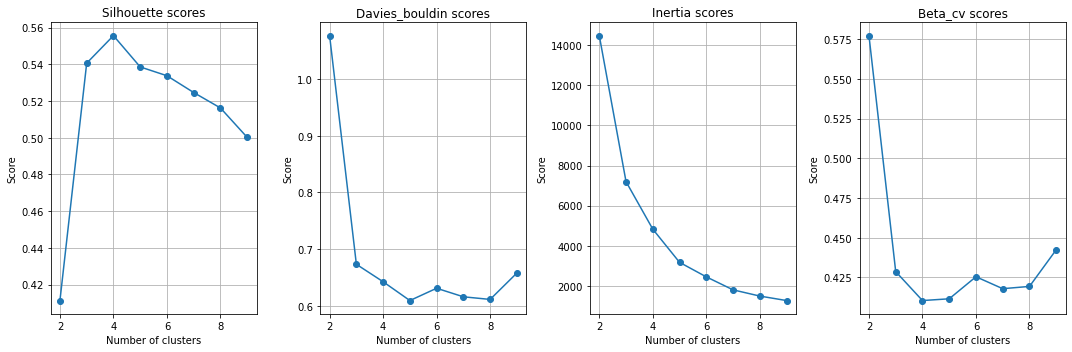

Evaluating clustering for 3D PCA data:


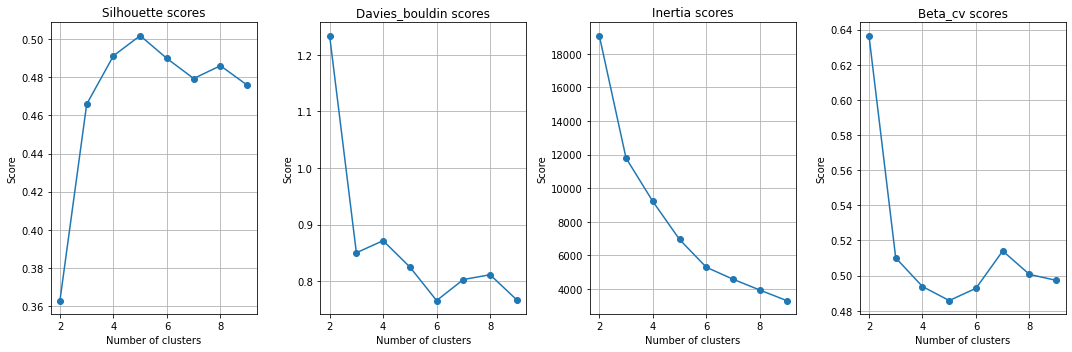

In [127]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial import distance

class ClusterEvaluator:
    def __init__(self, data, cluster_range):
        self.data = data
        self.cluster_range = cluster_range
        self.scores = {}

    def calculate_scores(self):
        for n_clusters in self.cluster_range:
            kmeans = KMeans(n_clusters=n_clusters)
            cluster_labels = kmeans.fit_predict(self.data)

            self.scores[n_clusters] = {
                'silhouette': silhouette_score(self.data, cluster_labels),
                'davies_bouldin': davies_bouldin_score(self.data, cluster_labels),
                'beta_cv': self.beta_cv(self.data, cluster_labels),
                'inertia': kmeans.inertia_
            }

    def beta_cv(self, data, labels):
        n_cluster = len(np.bincount(labels))
        intra_dists = np.zeros(n_cluster)
        inter_dists = np.zeros((n_cluster, n_cluster))

        for i in range(n_cluster):
            data_i = data[labels == i]

            intra_dists[i] = np.mean(distance.pdist(data_i))

            for j in range(n_cluster):
                if j != i:
                    data_j = data[labels == j]
                    inter_dists[i, j] = np.mean([distance.euclidean(point_i, point_j) for point_i in data_i for point_j in data_j])

        beta_cv = np.sum([intra_dists[i] / np.min([inter_dists[i, j] for j in range(n_cluster) if j != i]) for i in range(n_cluster)]) / n_cluster

        return beta_cv

    def plot_scores(self):
        fig, axs = plt.subplots(1, 4, figsize=(15, 5))
        for i, score_type in enumerate(['silhouette', 'davies_bouldin', 'inertia', 'beta_cv']):
            scores = [self.scores[n][score_type] for n in self.cluster_range]
            axs[i].plot(self.cluster_range, scores, marker='o')
            axs[i].set_title(f'{score_type.capitalize()} scores')
            axs[i].set_xlabel('Number of clusters')
            axs[i].set_ylabel('Score')
            axs[i].grid(True)

        plt.tight_layout()
        plt.show()

# Define a range of possible cluster numbers
cluster_range = range(2, 10)

# Create ClusterEvaluator instances for 2D and 3D data
evaluator_2d = ClusterEvaluator(X_pca_2d, cluster_range)
evaluator_3d = ClusterEvaluator(X_pca_3d, cluster_range)

# Calculate scores
evaluator_2d.calculate_scores()
evaluator_3d.calculate_scores()

# Plot scores
print("Evaluating clustering for 2D PCA data:")
evaluator_2d.plot_scores()

print("Evaluating clustering for 3D PCA data:")
evaluator_3d.plot_scores()


In [128]:
cluster_labels_2d = apply_kmeans(X_pca_2d, n_clusters=6)
visualize_2d_pca_interactive(X_pca_2d, labels=labels, clusters=cluster_labels_2d, title=title)

cluster_labels_3d = apply_kmeans(X_pca_3d, n_clusters=6)
visualize_3d_pca(X_pca_3d, labels=labels, clusters=cluster_labels_3d, title=title)


## Part 2.2: Decision Trees

#### Code can be found in decisionTree.py

Accuracy: 0.8805970149253731


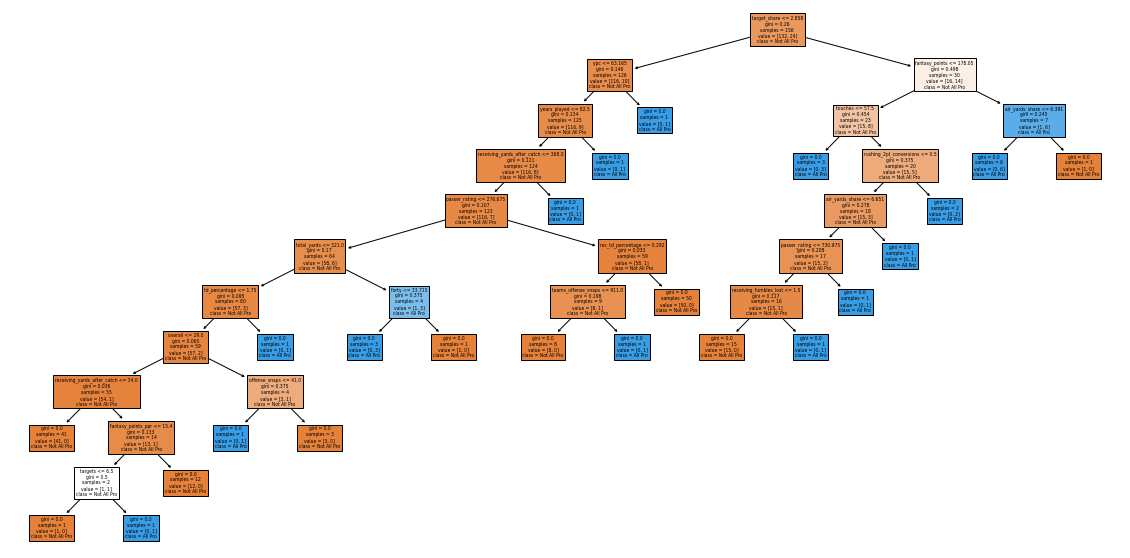

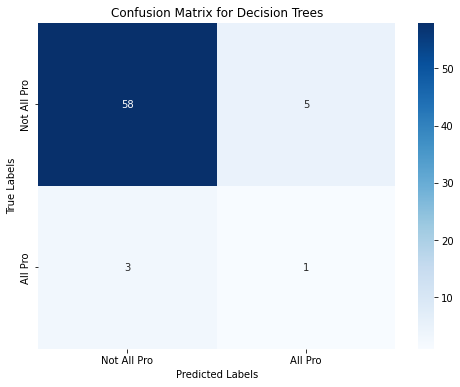

In [143]:
%run -i "decisionTree.py"

## Part 2.3: Support Vector Machines (SVM)

Accuracy: 0.9515669515669516
Classification Report:
              precision    recall  f1-score   support

 not all pro       0.95      1.00      0.98       334
     all pro       0.00      0.00      0.00        17

    accuracy                           0.95       351
   macro avg       0.48      0.50      0.49       351
weighted avg       0.91      0.95      0.93       351

Confusion Matrix:
[[334   0]
 [ 17   0]]


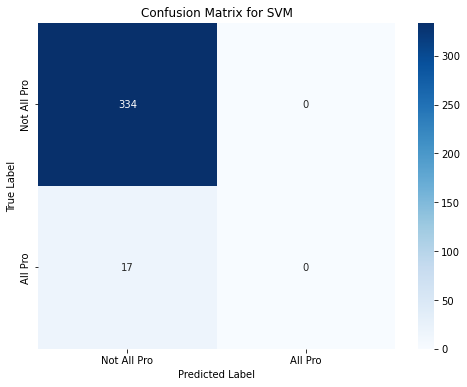

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.20)
svm_model = SVC()
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['not all pro', 'all pro'], zero_division=0))

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not All Pro', 'All Pro'],
            yticklabels=['Not All Pro', 'All Pro'])
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

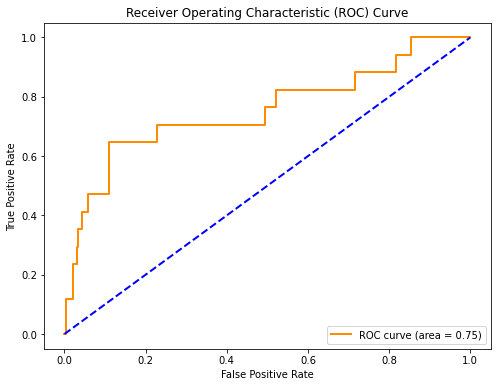

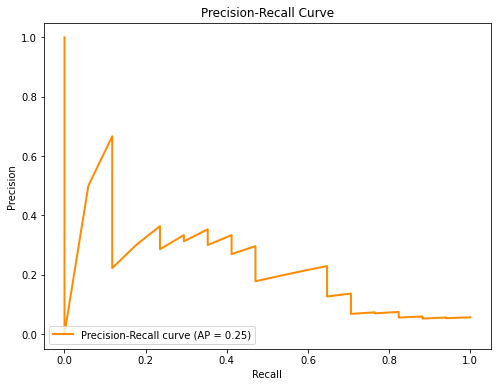

In [145]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

y_scores = svm_model.decision_function(X_test)
fpr, tpr, temp = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
precision, recall, temp = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

# ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

## Part 3: Supervised Learning Method

Accuracy: 0.9572649572649573
Classification Report:
              precision    recall  f1-score   support

 not all pro       0.96      1.00      0.98       337
     all pro       0.00      0.00      0.00        14

    accuracy                           0.96       351
   macro avg       0.48      0.50      0.49       351
weighted avg       0.92      0.96      0.94       351

Confusion Matrix:
[[336   1]
 [ 14   0]]


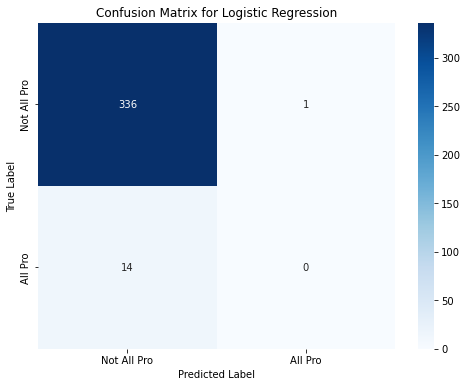

In [146]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['not all pro', 'all pro']))

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not All Pro', 'All Pro'],
            yticklabels=['Not All Pro', 'All Pro'])
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
